In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from tqdm import tqdm
tqdm.pandas()
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from lightgbm import LGBMClassifier
from IPython.display import FileLink

/home/ashutosh/miniconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# def file_link(dframe, fname='result.csv'):
#     dframe.to_csv(fname, index=False)
#     print(FileLink(fname))

In [3]:
train_file = 'train.csv'
test_file = 'test.csv'
filename = 'result.csv'

In [4]:
df, tdf = pd.read_csv(train_file), pd.read_csv(test_file)

In [5]:
df.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [6]:
for col in df.columns:
    print(df[col].value_counts(normalize=True, dropna=False, ascending=True))
    print(df[col].nunique())
    print("=========++++++++")

2049      0.000003
19875     0.000003
17826     0.000003
23969     0.000003
21920     0.000003
            ...   
19036     0.000003
29275     0.000003
31322     0.000003
107105    0.000003
2047      0.000003
Name: case_id, Length: 318438, dtype: float64
318438
=========++++++++
4     0.003894
7     0.004101
20    0.004412
18    0.011399
8     0.011503
16    0.011528
31    0.012458
22    0.013431
30    0.015708
2     0.016022
13    0.016443
1     0.016484
5     0.016521
17    0.017275
3     0.022347
24    0.025098
21    0.025594
15    0.029070
10    0.029629
25    0.030882
32    0.033611
12    0.035476
29    0.035520
9     0.036145
27    0.044731
28    0.053816
14    0.054416
11    0.054416
6     0.064141
19    0.066635
23    0.083426
26    0.103870
Name: Hospital_code, dtype: float64
32
=========++++++++
g    0.013431
f    0.033611
d    0.064028
e    0.077786
c    0.144229
b    0.216513
a    0.450402
Name: Hospital_type_code, dtype: float64
7
=========++++++++
13    0.011399
10    0.0

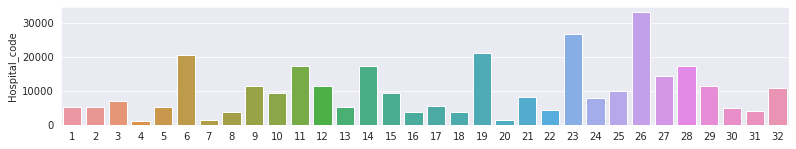

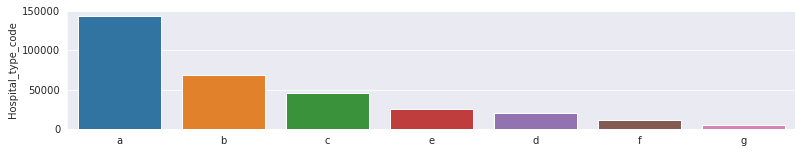

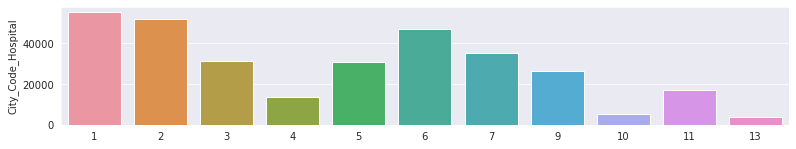

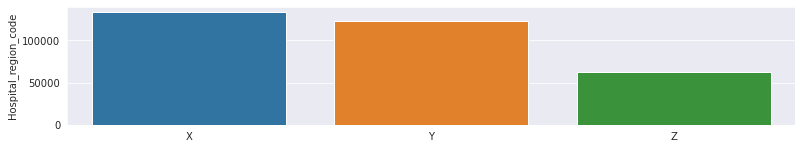

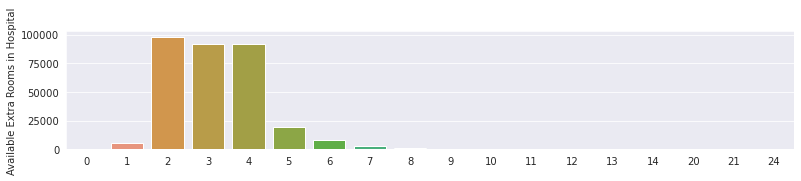

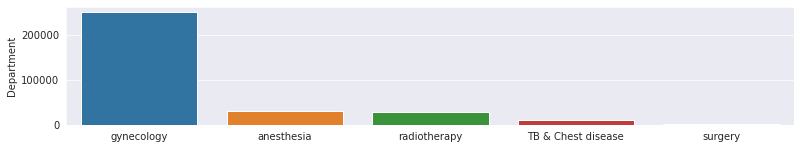

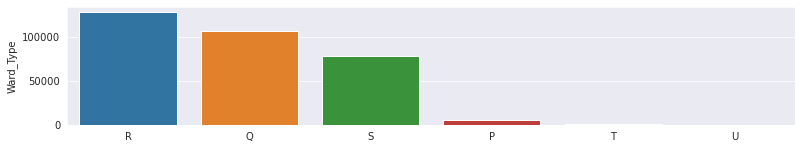

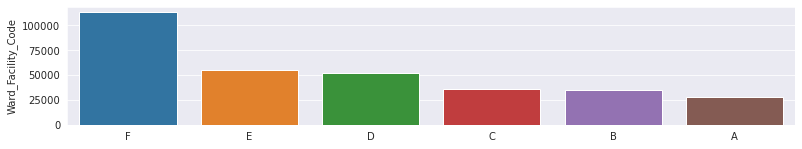

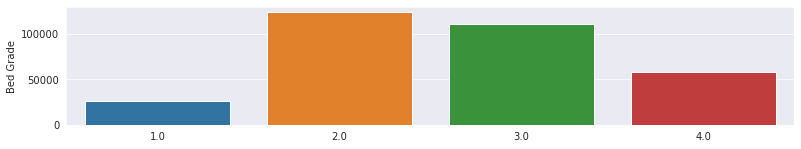

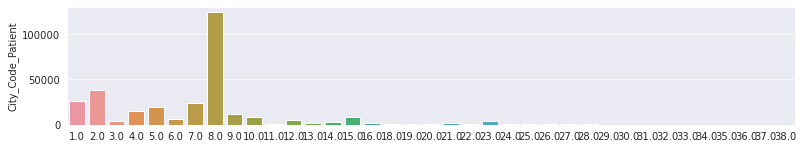

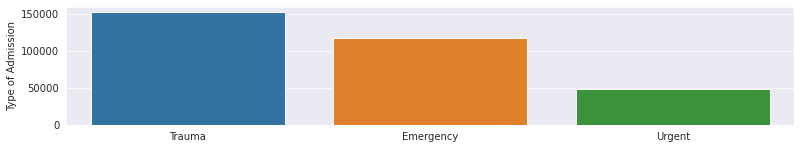

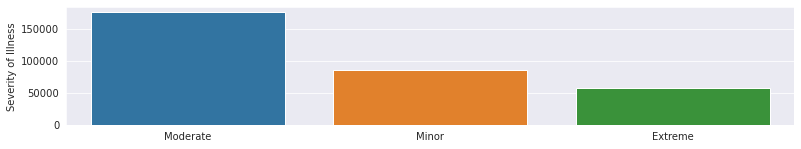

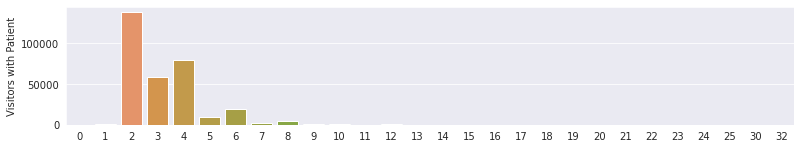

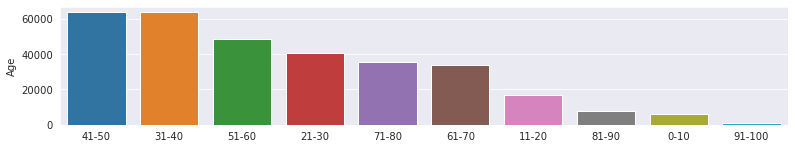

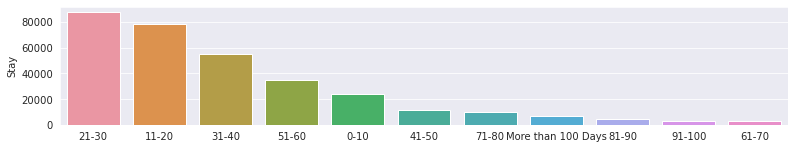

In [7]:
i = 1
for column in df.columns[~(df.columns.isin(['case_id', 'patientid', 'Admission_Deposit']))].tolist():
    plt.figure(figsize = (60, 10))
    plt.subplot(4, 4, i)
    sns.barplot(x = df[column].value_counts().index, y = df[column].value_counts())
    i += 1
    plt.show()

In [8]:
reg_cols = ['Admission_Deposit']
useless_cols = ['case_id', ]
cat_cols = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital','Department', 
            'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid' , 'City_Code_Patient', 'Type of Admission' , 'Severity of Illness', 
            'Visitors with Patient', 'Age', 'Stay']
len(reg_cols), len(useless_cols), len(cat_cols), len(df.columns)

(1, 1, 16, 18)

In [9]:
target_encoder = LabelEncoder()
def label_encoding(dframe, col, test=False):
    if col not in dframe.columns: return
    if col == 'Stay':
        if not test:
            dframe[col] = target_encoder.fit_transform(dframe[col])
        else:
            dframe[col] = target_encoder.transform(dframe[col])
    else:    
        label_encoder = LabelEncoder()
        dframe[col] = label_encoder.fit_transform(dframe[col])

df['Bed Grade'].fillna(-1, inplace=True)
tdf['Bed Grade'].fillna(-1, inplace=True)

df['City_Code_Patient'].fillna(0, inplace=True)
tdf['City_Code_Patient'].fillna(0, inplace=True)

df.fillna('NaN', inplace=True)
tdf.fillna('NaN', inplace=True)
for col in tqdm(cat_cols):
    label_encoding(df, col)
    label_encoding(tdf, col, True)
    

100%|██████████| 16/16 [00:00<00:00, 23.25it/s]


In [10]:
for col in df.columns:
    print(df[col].value_counts(normalize=True, dropna=False, ascending=True))
    print(df[col].nunique())
    print("=========++++++++")

2049      0.000003
19875     0.000003
17826     0.000003
23969     0.000003
21920     0.000003
            ...   
19036     0.000003
29275     0.000003
31322     0.000003
107105    0.000003
2047      0.000003
Name: case_id, Length: 318438, dtype: float64
318438
=========++++++++
3     0.003894
6     0.004101
19    0.004412
17    0.011399
7     0.011503
15    0.011528
30    0.012458
21    0.013431
29    0.015708
1     0.016022
12    0.016443
0     0.016484
4     0.016521
16    0.017275
2     0.022347
23    0.025098
20    0.025594
14    0.029070
9     0.029629
24    0.030882
31    0.033611
11    0.035476
28    0.035520
8     0.036145
26    0.044731
27    0.053816
13    0.054416
10    0.054416
5     0.064141
18    0.066635
22    0.083426
25    0.103870
Name: Hospital_code, dtype: float64
32
=========++++++++
6    0.013431
5    0.033611
3    0.064028
4    0.077786
2    0.144229
1    0.216513
0    0.450402
Name: Hospital_type_code, dtype: float64
7
=========++++++++
10    0.011399
8     0.0

In [11]:
ss = StandardScaler()
for col in tqdm(df.columns[~(df.columns.isin(['case_id', 'Stay']))].tolist()):
    df[[col]] = ss.fit_transform(df[[col]])

100%|██████████| 16/16 [00:00<00:00, 18.92it/s]


In [12]:
for col in tqdm(tdf.columns[~(tdf.columns.isin(['case_id', 'Stay']))].tolist()):
    tdf[[col]] = ss.fit_transform(tdf[[col]])

100%|██████████| 16/16 [00:00<00:00, 42.34it/s]


In [13]:
X = df[df.columns[~(df.columns.isin(['case_id', 'Stay']))].tolist()].values
y = df['Stay'].values

In [14]:
kfold, scores = KFold(n_splits = 6, shuffle = True, random_state = 22), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    model = CatBoostClassifier(random_state = 22, max_depth = 6, n_estimators = 200, verbose = 100, task_type="GPU", devices='0:1')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = metrics.accuracy_score(y_test, preds)
    scores.append(score)
    print('Validation Accuracy:', score)
print("Average Validation Accuracy: ", sum(scores)/len(scores))

Learning rate set to 0.5
0:	learn: 1.7948792	total: 38.8ms	remaining: 7.73s
100:	learn: 1.4574564	total: 3.35s	remaining: 3.29s
199:	learn: 1.4160362	total: 6.65s	remaining: 0us
Validation Accuracy: 0.4202890358562734
Learning rate set to 0.5
0:	learn: 1.7963113	total: 37ms	remaining: 7.36s
100:	learn: 1.4581294	total: 3.34s	remaining: 3.27s
199:	learn: 1.4147730	total: 6.62s	remaining: 0us
Validation Accuracy: 0.4222862849283063
Learning rate set to 0.5
0:	learn: 1.7938565	total: 37.3ms	remaining: 7.43s
100:	learn: 1.4581393	total: 3.42s	remaining: 3.36s
199:	learn: 1.4163876	total: 6.8s	remaining: 0us
Validation Accuracy: 0.42273849226537036
Learning rate set to 0.5
0:	learn: 1.7945041	total: 36.1ms	remaining: 7.18s
100:	learn: 1.4588243	total: 3.32s	remaining: 3.25s
199:	learn: 1.4186961	total: 6.59s	remaining: 0us
Validation Accuracy: 0.4213818702541782
Learning rate set to 0.5
0:	learn: 1.7930318	total: 36.6ms	remaining: 7.29s
100:	learn: 1.4591406	total: 3.33s	remaining: 3.27s
19

In [15]:


model = CatBoostClassifier(random_state = 22, max_depth = 6, n_estimators = 200, verbose = 100, task_type="GPU", devices='0:1')
model.fit(X, y)



Learning rate set to 0.5
0:	learn: 1.7933462	total: 41.5ms	remaining: 8.26s
100:	learn: 1.4635258	total: 3.82s	remaining: 3.75s
199:	learn: 1.4266618	total: 7.56s	remaining: 0us


In [16]:
predictions = model.predict(tdf[tdf.columns[~(tdf.columns.isin(['case_id']))].tolist()].values)
result = pd.DataFrame({'case_id': tdf['case_id'], 'Stay': predictions.ravel()})

In [17]:

result['Stay'] = target_encoder.inverse_transform(result['Stay'])

In [18]:
result.to_csv(filename, index=False)
FileLink(filename)

/home/ashutosh/code/AnalyticsVidhya_JANATAHACK/result.csv